In [1]:
import os 
import cv2 
import numpy as np 
from glob import glob 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 6
DATA_DIR = "C:/Users/oceanlightai/Desktop/datasets/pet_skin/train"
# NUM_TRAIN_IMAGES = 5100
# NUM_VAL_IMAGES = 900

In [3]:
# 데이터가 균일 하지 않음  
# train_images = sorted(glob(os.path.join(DATA_DIR, 'train_Image2/*')))[:NUM_TRAIN_IMAGES]
# train_masks = sorted(glob(os.path.join(DATA_DIR, 'train_mask2/*')))[:NUM_TRAIN_IMAGES]

# val_images = sorted(glob(os.path.join(DATA_DIR, 'train_Image2/*')))[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]
# val_masks = sorted(glob(os.path.join(DATA_DIR, 'train_mask2/*')))[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES+NUM_TRAIN_IMAGES]

In [ ]:
import os
from sklearn.model_selection import train_test_split

# 이미지 경로를 클래스별로 분류
images_per_class = {'A'+str(i): [] for i in range(1, NUM_CLASSES+1)}
for image_path in glob(os.path.join(DATA_DIR, '*.jpg')):
    class_id = image_path.split('_')[2]  # 파일 이름에서 class_id 추출
    images_per_class[class_id].append(image_path)

# 각 클래스별로 데이터를 학습 세트와 검증 세트로 분할
train_images = []
train_masks = []
val_images = []
val_masks = []

for class_id, images in images_per_class.items():
    train, val = train_test_split(images, test_size=0.15)  # 15%의 이미지를 검증 세트로 사용. 비율은 원하는 대로 조정할 수 있습니다.
    train_images.extend(train)
    train_masks.extend([image.replace('train_Image2', 'train_mask2') for image in train])  # 마스크 경로 생성
    val_images.extend(val)
    val_masks.extend([image.replace('train_Image2', 'train_mask2') for image in val])  # 마스크 경로 생성

In [4]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_jpeg(image, channels=1)  # 마스크는 JPG 파일로 저장되었다고 가정
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.float32) / 255.0  # 마스크를 [0, 1] 범위로 스케일링
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1  # 이미지는 -1에서 1 사이의 값으로 정규화

    return image

In [5]:
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

In [6]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [7]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("train dataset:" , train_dataset)
print("valid_dataset:", val_dataset)

train dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>
valid_dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [8]:
def convolution_block(block_input, num_filters=256, kernel_size=3, 
                     dilation_rate=1, padding='same', use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, 
                      dilation_rate=dilation_rate, padding='same', 
                      use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [9]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3]// x.shape[1], dims[-2]// x.shape[2]),
                                         interpolation='bilinear')(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    
    output = convolution_block(x, kernel_size=1)
    return output

In [10]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=model_input)
    
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1],
                                       image_size // 4 // x.shape[2]),
                                       interpolation='bilinear')(x)
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(image_size // x.shape[1],
                                 image_size // x.shape[2]),
                           interpolation='bilinear')(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1,1), padding='same')(x)
    
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3(image_size=IMAGE_SIZE, num_classes = NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6), 
              loss=loss,
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
750/750 [==============================] - 125s 153ms/step - loss: 1.5753 - accuracy: 0.4651 - val_loss: 1.6558 - val_accuracy: 0.8628
Epoch 2/30
750/750 [==============================] - 117s 156ms/step - loss: 0.6660 - accuracy: 0.9693 - val_loss: 0.4761 - val_accuracy: 0.9833
Epoch 3/30
750/750 [==============================] - 116s 154ms/step - loss: 0.3982 - accuracy: 0.9828 - val_loss: 0.3202 - val_accuracy: 0.9857
Epoch 4/30
750/750 [==============================] - 128s 170ms/step - loss: 0.2934 - accuracy: 0.9844 - val_loss: 0.2525 - val_accuracy: 0.9864
Epoch 5/30
750/750 [==============================] - 114s 152ms/step - loss: 0.2372 - accuracy: 0.9851 - val_loss: 0.2137 - val_accuracy: 0.9867
Epoch 6/30
750/750 [==============================] - 115s 153ms/step - loss: 0.1998 - accuracy: 0.9855 - val_loss: 0.1865 - val_accuracy: 0.9872
Epoch 7/30
750/750 [==============================] - 113s 151ms/step - loss: 0.1712 - accuracy: 0.9858 - val_loss: 0.1648 -

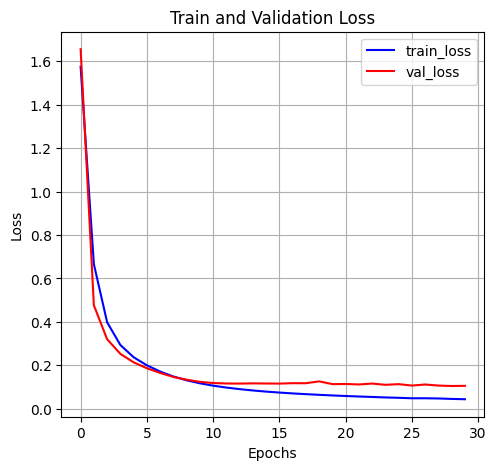

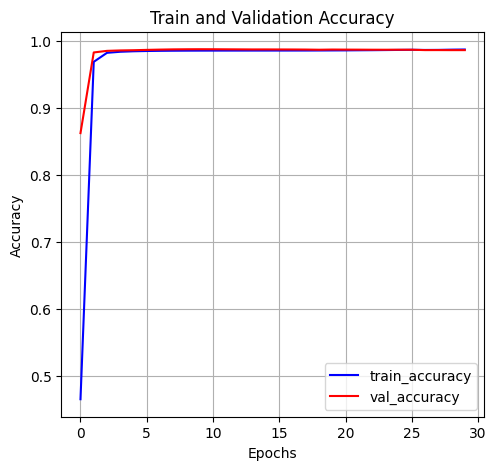

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(loss, color='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

fig = plt.figure(figsize=(12,5))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(loss, color='blue', label='train_accuracy')
ax2.plot(val_loss, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [25]:
unique, counts = np.unique(predicted_class_map, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 262144]]


# 추론

In [22]:
# 예측하고 싶은 이미지
test_image = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/valid/valid_image/IMG_D_A6_496649.jpg'

# 이미지를 모델의 입력으로 사용할 수 있도록 전처리
# 만약 이미지가 이미지 로딩 함수(read_image)를 통해 전처리된 경우, 이 과정은 생략 가능
test_image = read_image(test_image)
test_image = tf.expand_dims(test_image, axis=0)  # 배치 차원을 추가

# 이미지에 대한 예측 수행
predictions = model.predict(test_image)

# 예측 확률을 클래스 레이블로 변환
predicted_class_map = np.argmax(predictions, axis=-1)[0]

print(predicted_class_map)  # 예측된 클래스 맵을 출력

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


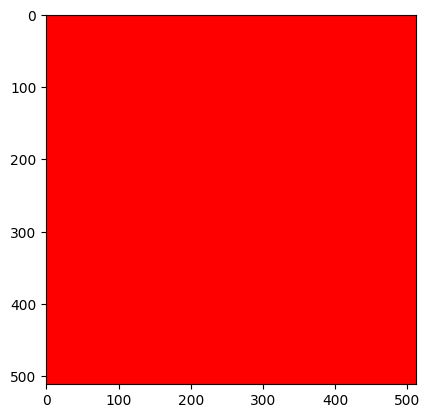

In [23]:
# 각 클래스에 대응하는 색상을 정의합니다. 이는 초기에 정의한 CLASS_DICT와 대응되어야 합니다.
color_map = {
    0: [255, 0, 0],  # Red
    1: [0, 255, 0],  # Green
    2: [0, 0, 255],  # Blue
    3: [255, 255, 0],  # Yellow
    4: [0, 255, 255],  # Cyan
    5: [255, 0, 255],  # Magenta
}

# 컬러 이미지를 저장할 빈 배열을 생성합니다.
color_image = np.zeros((predicted_class_map.shape[0], predicted_class_map.shape[1], 3), dtype=np.uint8)

# 각 픽셀에 대응하는 색상을 할당합니다.
for i in range(predicted_class_map.shape[0]):
    for j in range(predicted_class_map.shape[1]):
        color_image[i, j] = color_map[predicted_class_map[i, j]]

# 생성된 컬러 이미지를 표시합니다.
plt.imshow(color_image)
plt.show()